# Install Libraries

In [ ]:
!sudo apt install tree
!pip install -q gdown

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (66.3 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 160837 files and directories currently instal

# Downloading Data from **Google Drive**
> you can skip this part if you're mounting Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

!gdown --id 16XAo2mwUQrKo_D_-f3aYnxg5qioj6DUj ## pseudo.csv
!gdown --id 1uMQHjJuiOAcVQcU5IBb8tTzYNlIWyPpl ## evopose code
!gdown --id 1z3-avfdASYq4yZ3ZOBzAuoeyyHJg_J4i ## competition data

Downloading...
From: https://drive.google.com/uc?id=16XAo2mwUQrKo_D_-f3aYnxg5qioj6DUj
To: /content/pseudo.csv
100% 472k/472k [00:00<00:00, 3.84MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uMQHjJuiOAcVQcU5IBb8tTzYNlIWyPpl
To: /content/evopose2d.zip
56.2MB [00:00, 69.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z3-avfdASYq4yZ3ZOBzAuoeyyHJg_J4i
To: /content/data.zip
3.39GB [00:55, 60.8MB/s]


# Only For **Google Colab**
Run following two cells if you want to run it on 'Google Colab'

## Copy `competition Data` from **Drive** to **Current Directory**

In [ ]:
# %cp /content/drive/MyDrive/vipcup2021/data.zip /content/data.zip

# Extracting Files

In [ ]:
!mkdir -p /content/vipcup2021-dataset
!unzip -q /content/data.zip -d /content/vipcup2021-dataset

In [ ]:
!rm /content/data.zip

In [ ]:
!tree /content/vipcup2021-dataset -L 2

/content/vipcup2021-dataset
├── README.md
├── test1
│   └── test1
├── train
│   └── train
└── valid
    └── valid

6 directories, 1 file


# 1. Importing Libraries

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.io as scio
import pandas as pd
from tqdm.notebook import tqdm
import os, shutil
from glob import glob
tqdm.pandas()
import json
import datetime
import ast

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 2. Configs
Change directories accordingly
<!-- * **ROOT_DIR**: 
    * Root directory of the dataset, it should follow exact structure of the provided dataset. -->
* **MODEL_DIR** : 
    * Directory of the evopose model
```
    \MODEL_DIR
        evopose2d.zip
```
* **AUG_DIR**: 
    * Diretory of the Augmented Dataset.
```
    \AUG_DIR
        \train
        \valid
```
* **DATA_DIR**: 
    * Directory to save the `tfrecord` dataset for **EvoPose2D**.
* **PSEUDO_DIR**:
    * Directory to `pseudo-labels`
```
    \PSEUDO_DIR
        info.json
```

In [7]:
# ROOT_DIR = '/kaggle/input/vip-cup-2021-transformed-images-dataset' # old-format # directory of competition data
MODEL_DIR  = '/content'
AUG_DIR    = '/content/vipcup2021-aug-dataset' # new-format # directory of augmented data
DATA_DIR   = '/content/vipcup2021-dataset' # directory of the 'training' dataset

# directory of the pseudo-label-data
PSEUDO_DIR = None 

# best pseudo.csv from Google Drive for partial training
PSEUDO_CSV = '/content/pseudo.csv' # /content/pseudo.csv or None

# dimension of the dataset, aspect ratio is maintained so [512, 384]
DIM = 512 # 512

In [8]:
%%writefile generate_cover.py

import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2,os
from glob import glob
import scipy.io as scio
import scipy
import shutil
from matplotlib.colors import rgb2hex
from skimage.morphology import reconstruction
from skimage.morphology import disk
from skimage.filters.rank import gradient
import skimage
from tqdm import tqdm
os.system('pip install git+https://github.com/albumentations-team/albumentations')
import albumentations as A

kplines = [(0, 1), (1, 2), (12, 2), (12, 3), (3, 4), (4, 5), (6, 7),
            (7, 8), (8, 12), (12, 9), (9, 10), (10, 11), (12, 13)]
name2idx = {
    "Right ankle":0,
    "Right knee":1,
    "Right hip":2,
    "Left hip":3,
    "Left knee":4,
    "Left ankle":5,
    "Right wrist":6,
    "Right elbow":7,
    "Right shoulder":8,
    "Left shoulder":9,
    "Left elbow":10,
    "Left wrist":11,
    "Thorax":12,
    "Head top":13, 
}
idx2name = {v:k for k,v in name2idx.items()}

def load_kps(kp_path):
    gt  = scio.loadmat(kp_path)['joints_gt']
    kps = gt[:2].transpose(2, 1, 0) # => (num_image, num_limb, 2) => (None, 14, 2)
    return kps.astype(int)

def draw_kp(img, kps, kplines, line_th=1, circle_th=2, fontScale=1, text_th =2, text=False):
    """
    Args:
        img      : image (R, G, B)
        kps      : keypoints (num_points, 2)
        kplines  : limb line tuple index
        text     : show text or not
    Returns:
        drew image
    """
    cmap   = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kps) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]
    for idx, kpline in enumerate(kplines):
        img = cv2.line(img.astype(float), tuple(kps[kpline[0]]), tuple(kps[kpline[1]]), thickness=line_th,
                       color=colors[idx], lineType=cv2.LINE_AA)
    for idx in range(len(kps)):
        color = colors[idx]
        img = cv2.circle(img.astype(float),tuple(kps[idx]), circle_th, color , cv2.FILLED)
        if text:
            w = img.shape[1]
            px = kps[idx][0]
            py = kps[idx][1]
            if px>w//2:
                px+=10
                color = (255,0,0)
            else:
                px-=30
                color = (0,0,255)
            img = cv2.putText(img, str(idx), (px, py), cv2.FONT_HERSHEY_SIMPLEX, 
                               fontScale=fontScale, color=color, thickness=text_th, lineType=cv2.LINE_AA)
    return img.astype('uint8')


            
def apply_selective_thorax(main_img,transformed_image,point):
    extra=int(point)
    new_img=main_img.copy()
    new_img[extra:,:]=transformed_image[extra:,:]
    return new_img

def pad_across_width(image):
    shapes=image.shape
    h=shapes[0]
    w=shapes[1]
    if len(shapes)>2:
        c=shapes[-1]

    diff=h-w
    side1=int(diff/2)
    side2=diff-side1

    s1=np.zeros((h,side1)).astype(image.dtype) if len(shapes)==2 else np.zeros((h,side1,c)).astype(image.dtype) 
    s2=np.zeros((h,side2)).astype(image.dtype) if len(shapes)==2 else np.zeros((h,side2,c)).astype(image.dtype) 

    new_image=image.copy()
    new_image=np.concatenate([s1,new_image,s2],axis=1)
    return new_image
tpoint=name2idx["Thorax"]

def cover_gen(points,image,return_coord=False):
    cover=np.zeros(image.shape,dtype=image.dtype)
    
    cover_corner_right=points[:,0].max()+20
    cover_corner_left=points[:,0].min()-20
    low=150
    hthorax=points[tpoint][1]

    if len(image.shape)>2:
        cover[hthorax:low,cover_corner_left:cover_corner_right,0]=1# if image.dtype=='uint8' else 255.0
        cover=cover[:,:,0]
    else:
        cover[hthorax:low,cover_corner_left:cover_corner_right]=1 #if image.dtype=='uint8' else 255.0
    
    if return_coord:
        return ((cover_corner_left,hthorax),(cover_corner_right,low)),cover
    return cover

def combine(image,path1,path2):
    albu=A.Compose([
                   A.augmentations.domain_adaptation.HistogramMatching(path2,blend_ratio=(0.5, 0.9),p=1),
    A.augmentations.domain_adaptation.FDA(path1,p=1,beta_limit=0.05)])
    albu_im= albu(image=image)['image']
    return albu_im

def combiner(image1,image2,cover,final_channel=1):
    if len(cover.shape)==2:
        cover=np.expand_dims(cover,axis=-1)
    if len(image2.shape)==2:
        image2=np.expand_dims(image2,axis=-1)
    
    if len(image1.shape)>2&image1.shape[-1]!=1:
        image1=np.expand_dims(image1[:,:,0],axis=-1)
    
    total=(1-cover)*image1+cover*image2
    if final_channel==3:
        return np.stack([total,total,total])
    return total

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir', type=str, default='/kaggle/input/ieee-vip-cup-2021-train-val-dataset/', help='main directory of data')
    parser.add_argument('--save-dir', type=str, default='/kaggle/working/VIP',help="where to save files, a new directory")
    opt = parser.parse_args()
    
    save_at=opt.save_dir#'/kaggle/working'
    global_path=opt.data_dir
    
#     if os.path.exists(save_at):
#         save_at=os.path.join(save_at,'VIP')
        
    print('Copying ...')
    try:
        shutil.copytree(global_path,save_at)
    except:
        shutil.rmtree(save_at)
        shutil.copytree(global_path,save_at)
    
    print('Finding Train statistics...')
    
    uncover=[]
    cover1=[]
    cover2=[]
    files_dir=os.path.join(global_path,'train')
    if len(os.listdir(files_dir))<4:
        files_dir=os.path.join(files_dir,'train')
    files=os.listdir(files_dir)
    uncover_images_list=[]
    for f in files:
        current_dir=os.path.join(files_dir,f,'IR')
        if 'uncover' in os.listdir(current_dir):
            uncover.append(f)
            uncover_images_list.extend(glob(os.path.join(current_dir,'uncover/*')))

        if 'cover1' in os.listdir(current_dir):
            cover1.append(f)
        if 'cover2' in os.listdir(current_dir):
            cover2.append(f)

    print(f'Uncover dirs : {len(uncover)}, Total files: {len(uncover_images_list)}')
    print(f'Cover1 dirs : {len(cover1)}')
    print(f'Cover2 dirs : {len(cover2)}')
    
    cover2_path=['image_000027.png',
     'image_000041.png',
     'image_000038.png',
     'image_000023.png']
    
    cover2_path=[os.path.join(files_dir,'00062/IR/cover2',i) for i in cover2_path]
    print('Selected cover images are : ',cover2_path)
    
    copy_dir=os.path.join(save_at,'train')
    if len(os.listdir(copy_dir))<5:
        copy_dir=os.path.join(copy_dir,'train')
        
    print('Generating cover images from uncover')   
    for file_num in tqdm(sorted(uncover)):
        image_dir=sorted(glob(os.path.join(copy_dir,file_num,'IR','uncover','*')))
        keypoints_path=os.path.join(copy_dir,file_num,'joints_gt_IR.mat')

        kp=load_kps(keypoints_path)
        for i in range(len(image_dir)):
            image_path=image_dir[i]

            image=cv2.imread(image_path)
            point=kp[i-1]
            ((x1,y1),(x2,y2)),cover=cover_gen(point,image[:,:,0],return_coord=True)
            final_im=combine(image,cover2_path,cover2_path)
            final_im=combiner(image,final_im,cover)

            cv2.imwrite(image_dir[i],final_im)
    print('Completed')

Writing generate_cover.py


In [9]:
!python generate_cover.py --data-dir $DATA_DIR --save-dir $AUG_DIR

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rtf3mg8b
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rtf3mg8b
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=98951 sha256=43b52ba81baab48dc1c4f2efa9460eb9592be99c30cdc390686bb0ea6dbd6541
  Stored in directory: /tmp/pip-ephem-wheel-cache-7aopo3dd/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Copying ...
Finding Train statistics...
Uncover dirs : 30, Total files: 1350
Cover1 dirs : 25
Cover2 dirs : 25
Selected cover images are :  ['/content/vipcup2021-dataset/train/train/00062/IR/cover2/image_000027.png', '/content/vipcup2021-dataset/train/train/00062/IR/cover2/image

## Key-Point Config

In [10]:
KPLINES = [(0, 1), (1, 2), (12, 2), (12, 3), (3, 4), (4, 5), (6, 7),
            (7, 8), (8, 12), (12, 9), (9, 10), (10, 11), (12, 13)]
SKELETON = [[x[0]+1, x[1]+1] for x in KPLINES]
NAME2IDX = {
    "Right ankle":0,
    "Right knee":1,
    "Right hip":2,
    "Left hip":3,
    "Left knee":4,
    "Left ankle":5,
    "Right wrist":6,
    "Right elbow":7,
    "Right shoulder":8,
    "Left shoulder":9,
    "Left elbow":10,
    "Left wrist":11,
    "thorax":12,
    "head top":13, 
}
IDX2NAME = {v:k for k,v in NAME2IDX.items()}
KP_NAMES = list(IDX2NAME.values())
KP_LABELS = list(IDX2NAME.keys())
NAME2IDX, IDX2NAME

({'Left ankle': 5,
  'Left elbow': 10,
  'Left hip': 3,
  'Left knee': 4,
  'Left shoulder': 9,
  'Left wrist': 11,
  'Right ankle': 0,
  'Right elbow': 7,
  'Right hip': 2,
  'Right knee': 1,
  'Right shoulder': 8,
  'Right wrist': 6,
  'head top': 13,
  'thorax': 12},
 {0: 'Right ankle',
  1: 'Right knee',
  2: 'Right hip',
  3: 'Left hip',
  4: 'Left knee',
  5: 'Left ankle',
  6: 'Right wrist',
  7: 'Right elbow',
  8: 'Right shoulder',
  9: 'Left shoulder',
  10: 'Left elbow',
  11: 'Left wrist',
  12: 'thorax',
  13: 'head top'})

# 3. Meta Data
Get meta information of the **Competition** Data, example: `study_id` or `image_id`
* **study_id** : Patient ID, Unique id to a patient. ex: 001
* **image_id** : Image ID, Unique id to a image. ex: image_001.png
* **label** : Whether `uncover`, `cover1` or `cover2`.
* **split** : Whether `train` or `valid`.
* **modality** : Whether `IR` or `RGB`.
* **filename** : {`study_id`}_{`image_id`}
* **ir_gt_path** : KeyPoints Paths of `.mat` file

## Competition Data

In [11]:
def get_info(filepath):
    x = filepath.split('/')
    image_id = x[-1]
    label    = x[-2]
    modality = x[-3]
    study_id = x[-4]
    split    = x[-5]
    return [filepath, study_id, image_id,modality, label, split]
# def kp_path(path):
#     keywords = {
#         f"train{os.sep}train":"train",
#         f"valid{os.sep}valid":"valid",
#     }
#     for w, r in keywords.items():
#         path = path.replace(w, r)

In [12]:
filepaths = glob(f'{AUG_DIR}/**/*png', recursive=True) # get all filepaths
df = pd.DataFrame(list(map(get_info, filepaths)),
                  columns=['image_path', 'study_id', 'image_id','modality', 'label', 'split'])
df['filename']    = df['study_id']+'_'+df['image_id'] # set filename
df['ir_gt_path']  = df.image_path.map(lambda x: os.path.join(x.rsplit('/', 3)[0], 'joints_gt_IR.mat'))

df = df[df.modality=='IR'].reset_index(drop=True) # take only IR images

print('Size of the Dataset:',df.shape[0])
df.head()

Size of the Dataset: 4500


,image_path,study_id,image_id,modality,label,split,filename,ir_gt_path
0,/content/vipcup2021-aug-dataset/train/train/00...,00040,image_000004.png,IR,cover1,train,00040_image_000004.png,/content/vipcup2021-aug-dataset/train/train/00...
1,/content/vipcup2021-aug-dataset/train/train/00...,00040,image_000015.png,IR,cover1,train,00040_image_000015.png,/content/vipcup2021-aug-dataset/train/train/00...
2,/content/vipcup2021-aug-dataset/train/train/00...,00040,image_000027.png,IR,cover1,train,00040_image_000027.png,/content/vipcup2021-aug-dataset/train/train/00...
3,/content/vipcup2021-aug-dataset/train/train/00...,00040,image_000029.png,IR,cover1,train,00040_image_000029.png,/content/vipcup2021-aug-dataset/train/train/00...
4,/content/vipcup2021-aug-dataset/train/train/00...,00040,image_000002.png,IR,cover1,train,00040_image_000002.png,/content/vipcup2021-aug-dataset/train/train/00...


## Train-Valid Distribution

In [13]:
df.split.value_counts()

train    3600
valid     450
test1     450
Name: split, dtype: int64

## Helper

In [14]:
import scipy.io as scio
import cv2

def load_kps(kp_path):
    gt  = scio.loadmat(kp_path)['joints_gt'] # label = if_ocluded
    kps = gt.transpose(2, 1, 0).astype(np.float64) # => (num_image, num_limb, 3) or (None, 14, 3)
    kps[..., 0] = (kps[...,0]-1)  # converting one indexing to zero indexing
    kps[..., 1] = (kps[...,1]-1)
    kps[..., 2] = 2- kps[...,2]
    return kps.astype(np.int32)

def rescale_kps(kps, width=120, height=160):
    kps = np.array(kps)
    kps[...,0] = kps[...,0]/120*width
    kps[...,1] = kps[...,1]/160*height
    return kps

def load_image(image_path):
    return cv2.imread(image_path)[...,::-1]

def read_resize(file_path, dim=-1, ar=True):
    img = load_image(file_path)
    h, w = img.shape[:2]  # orig hw
    if dim==-1:
        return img, w, h
    if ar:
        r = dim / max(h, w)  # resize image to img_size
        interp = cv2.INTER_AREA if r < 1 else cv2.INTER_LINEAR
        if r != 1:  # always resize down, only resize up if training with augmentation
            img = cv2.resize(img, (int(w * r), int(h * r)), interpolation=interp)
            new_h, new_w = img.shape[:2]
    else:
        img = cv2.resize(img, (dim, dim), cv2.INTER_AREA)
        new_w = dim; new_h = dim
        
    return img, w, h

def draw_kp(img, kps, kplines, line_th=4, circle_th=10, fontScale=1, text_th =2, text=False):
    """
    Args:
        img      : image
        kps      : keypoints
        kplines  : limb line tuple index
        text     : show text or not
    Returns:
        drew image
    """
    cmap   = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kps) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]
    for idx, kpline in enumerate(kplines):
        img = cv2.line(img.astype(float), tuple(kps[kpline[0]]), tuple(kps[kpline[1]]), thickness=line_th,
                       color=colors[idx], lineType=cv2.LINE_AA)
    for idx in range(len(kps)):
        color = colors[idx]
        img = cv2.circle(img.astype(float),tuple(kps[idx]), circle_th, color , cv2.FILLED)
        if text:
            w = img.shape[1]
            px = kps[idx][0]
            py = kps[idx][1]
            if px>w//2:
                px+=10
                color = (255,0,0)
            else:
                px-=30
                color = (0,0,255)
            img = cv2.putText(img, IDX2NAME[idx], (px, py), cv2.FONT_HERSHEY_SIMPLEX, 
                               fontScale=fontScale, color=colors[idx], thickness=text_th, lineType=cv2.LINE_AA)
    return img.astype('uint8')

## Load Key-Points

In [15]:
tqdm.pandas(desc='Loading KeyPoints ')
def get_kps(row):
    try:
        kp_path   = row['ir_gt_path']
        kps        = load_kps(kp_path).tolist()
        img_idx    = int(row["image_id"].split('.')[0].split('_')[-1])-1 # image is 1 indexed but array is 0 indexed
        row['kps'] = kps[img_idx]
    except:
        row['kps'] = -1
    return row
df = df.progress_apply(get_kps, axis=1)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 4. COCO Format Dataset
`tfrec` dataset requires a **COCO** format dataset. Augmented Dataset is converted to **COCO** format in the following cell.

## Creating Directory for `tfrec` Dataset

In [16]:
coco_dir  = f'{DATA_DIR}/coco2017'
train_dir = f'{DATA_DIR}/coco2017/train2017'
val_dir   = f'{DATA_DIR}/coco2017/val2017'
annot_dir = f'{DATA_DIR}/coco2017/annotations'
tfrec_dir = f'{DATA_DIR}/tfrecord/'
try:
    shutil.rmtree(train_dir)
    shutil.rmtree(val_dir)
    shutil.rmtree(annot_dir)
    shutil.rmtree(tfrec_dir)
except:
    print('=> Datasets not created yet')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir,   exist_ok=True)
os.makedirs(annot_dir, exist_ok=True)
os.makedirs(tfrec_dir, exist_ok=True)
print('\nCOCO :',coco_dir)
print('TRAIN:',train_dir)
print('VAlid:',val_dir)
print('ANNOT:',annot_dir)
print('TFREC:',tfrec_dir)

=> Datasets not created yet

COCO : /content/vipcup2021-dataset/coco2017
TRAIN: /content/vipcup2021-dataset/coco2017/train2017
VAlid: /content/vipcup2021-dataset/coco2017/val2017
ANNOT: /content/vipcup2021-dataset/coco2017/annotations
TFREC: /content/vipcup2021-dataset/tfrecord/


## COCO Helper

In [17]:
def get_image_info(file_name, height, width, id,
                   license=1, date_captured='', 
                   coco_url='', flickr_url='',):
    return dict(license=license, 
                file_name=file_name,
                coco_url=coco_url,
                height=height,
                width=width, 
                date_captured=date_captured,
                flickr_url=flickr_url,
                id=id)

def get_annot_info(kps, id, image_id, category_id=1, bbox=None, area=None,
                   iscrowd=0, segmentation=None):
    """
    Parameters:
    --------------- 
    Args:
    
    Returns:
    
    """
    return {
        "segmentation": segmentation or [],
        "num_keypoints": len(kps)//3,
        "area": area if area else (bbox[2]*bbox[3]),
        "iscrowd": iscrowd,
        "keypoints": kps,
        "image_id": image_id,
        "bbox": bbox or [0, 0, 0, 0],
        "category_id": category_id,
        "id": id,
    }

## Common

In [18]:
INFO = {
    "description": "VIP CUP 2021 Dataset",
    "url": "",
    "version": "0.1.0",
    "year": 2021,
    "contributor": "",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "",
        "url": ""
    }
]

CATEGORIES = [
    {
        'id': 1,
        'name': 'person',
        'supercategory': 'person',
        "keypoints": KP_NAMES,
        "skeleton": SKELETON,
    },
]

coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],
    "annotations": []
}

# 4.1 Train Dataset
Train data will be created in COCO format here. 

## 4.1.1 Augmented `uncover` Data

In [19]:
train_df   = df[(df.label=='uncover') & (df.split=='train')]
val_df     = df[(df.split=='valid')]
print('Train Data:', train_df.shape[0])
print('Valid Data:', val_df.shape[0])

Train Data: 1350
Valid Data: 450


## 4.1.2 Pseudo-Labled `cover1` & `cover2` Data
For **Pseudo** traiining, pseudo-labeled cover1 & cover2 data is concatenated with train data.

In [20]:
if PSEUDO_DIR or PSEUDO_CSV:
    pseudo_df  = df[(df.label!='uncover') & (df.split=='train')]
    del pseudo_df['kps']
    print('Pseudo Data:',pseudo_df.shape[0])
    if not PSEUDO_CSV:
      json_path = glob(os.path.join(PSEUDO_DIR, '**/*/info.json'), recursive=True)[0]
      cover_file = open(json_path, 'r')
      cover_data = json.load(cover_file)
      cover_paths, cover_kps = list(cover_data.keys()), list(cover_data.values())
      cover_names = list(map(lambda x: x.split('/')[-1], cover_paths))
      cover_kps = np.array(cover_kps)
      cover_kps = np.concatenate([cover_kps, np.full(cover_kps[..., :1].shape, 2)], axis=-1).tolist() # set opacity==2 for all kps
      tmp_df    = pd.DataFrame({'filename':cover_names,
                            'kps':cover_kps})
    else:
      tmp_df = pd.read_csv(PSEUDO_CSV)
      tmp_df['kps'] = tmp_df['kps'].map(lambda x: ast.literal_eval(x))
    pseudo_df = pseudo_df.merge(tmp_df, on='filename', how='left')
    train_df  = pd.concat([train_df, pseudo_df], axis=0).reset_index(drop=True) # concat with train data
    print('Train + Pseudo Data:',train_df.shape[0])
    pseudo_df.to_csv(f'{DATA_DIR}/pseudo.csv',index=False) # use this pseudo for other models
    display(train_df.head(2))

Pseudo Data: 2250
Train + Pseudo Data: 3600


,image_path,study_id,image_id,modality,label,split,filename,ir_gt_path,kps
0,/content/vipcup2021-aug-dataset/train/train/00...,00023,image_000004.png,IR,uncover,train,00023_image_000004.png,/content/vipcup2021-aug-dataset/train/train/00...,"[[52, 133, 2], [52, 108, 2], [52, 82, 2], [72,..."
1,/content/vipcup2021-aug-dataset/train/train/00...,00023,image_000015.png,IR,uncover,train,00023_image_000015.png,/content/vipcup2021-aug-dataset/train/train/00...,"[[55, 131, 2], [52, 105, 2], [52, 78, 2], [75,..."


## Creating Dataset ...

In [21]:
IMAGES = []
ANNOTATIONS = []
coco_image_id=1
coco_annot_id=1
for idx in tqdm(range(train_df.shape[0]), desc='train_dataset '):
    image_path = train_df.image_path.iloc[idx]
    image_id   = train_df.image_id.iloc[idx]
    study_id   = train_df.study_id.iloc[idx]
    image_idx  = int(image_id.split('.')[0].split('_')[-1])-1
    label      = train_df.label.iloc[idx]
    split      = train_df.split.iloc[idx]
    image, width, height  = read_resize(image_path, dim=DIM, ar=True)
    new_height, new_width = image.shape[:2]
    kps   = rescale_kps(train_df.kps.iloc[idx], new_width, new_height) # resacle the kp to the new image-size
    # kp of a image
    kps_img = kps
    # bbox from keypoints
    xmin, ymin, xmax, ymax = np.min(kps_img[...,0]), np.min(kps_img[...,1]), np.max(kps_img[...,0]), np.max(kps_img[...,1])
    xmin, ymin = int(xmin-15), int(ymin-15) # kp are too close to body so taking offset
    w,h = int(xmax-xmin+35), int(ymax-ymin+35)
    bbox = [xmin, ymin, w, h]
    #============================
    kps_img = [int(x) for x in kps_img.reshape(-1).tolist()]
    
    file_name = split+'_'+label+'_'+study_id+'_'+image_path.split('/')[-1] # image_name = split_label_study_id_image_id
    new_image_path  = os.path.join(train_dir,file_name)
    # writing image
    cv2.imwrite(new_image_path, image[...,::-1])
    # writing data
    IMAGES.append(get_image_info(file_name, 
                                 height=int(new_height), 
                                 width=int(new_width), 
                                 id=coco_image_id,))
    ANNOTATIONS.append(get_annot_info(kps=kps_img, id=coco_annot_id, image_id=coco_image_id, category_id=1,
                                      bbox=bbox, 
                                      area=w*h,
                                      iscrowd=0,
                                      segmentation=None))
    coco_image_id+=1
    coco_annot_id+=1
#===========================
coco_output["images"]      = IMAGES
coco_output["annotations"] = ANNOTATIONS

# json file
with open('{}/person_keypoints_train2017.json'.format(annot_dir), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)

## Sanity Check
This cell will through an error if the dataset is not successfully created

In [22]:
assert len(IMAGES)==len(glob(train_dir+'**/*png',recursive=True)) # check if all images are found

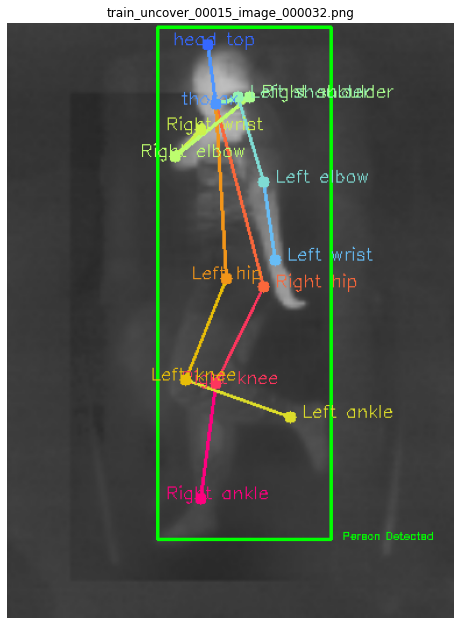

In [23]:
idx=380
filename = IMAGES[idx]['file_name']
path = '{}/{}'.format(train_dir, filename)
img = load_image(path)
# img = image
x, y, w, h = ANNOTATIONS[idx]['bbox']
kps = np.array(ANNOTATIONS[idx]['keypoints']).reshape(14, 3)[...,:2]
img = cv2.rectangle(img.astype(float),(x,y),(x+w,y+h),(0,255,0),2)
img = cv2.putText(img,'Person Detected',(x+w+10,y+h),0,0.3,(0,255,0))
img = draw_kp(img, kps, KPLINES, line_th=2, circle_th=5, fontScale=0.5, text_th =1, text=True)
plt.figure(figsize=(8,12))
plt.imshow(img.astype(np.uint8))
plt.axis('OFF')
plt.title(filename);

In [24]:
len(IMAGES), len(glob(train_dir+'**/*png',recursive=True))

(3600, 3600)

# 4.2 Val Dataset

In [25]:
IMAGES = []
ANNOTATIONS = []
coco_image_id=1
coco_annot_id=1
for idx in tqdm(range(val_df.shape[0])):
    image_path = val_df.image_path.iloc[idx]
    image_id   = val_df.image_id.iloc[idx]
    study_id   = val_df.study_id.iloc[idx]
    image_idx  = int(image_id.split('.')[0].split('_')[-1])-1
    label      = val_df.label.iloc[idx]
    split      = val_df.split.iloc[idx]
    image, width, height  = read_resize(image_path, dim=DIM, ar=True)
    new_height, new_width = image.shape[:2]
    kps   = rescale_kps(val_df.kps.iloc[idx], new_width, new_height)
    # kp of a image
    kps_img = kps
    # bbox from keypoints
    xmin, ymin, xmax, ymax = np.min(kps_img[...,0]), np.min(kps_img[...,1]), np.max(kps_img[...,0]), np.max(kps_img[...,1])
    xmin, ymin = int(xmin-15), int(ymin-15) # kp are too close to body so taking offset
    w,h = int(xmax-xmin+35), int(ymax-ymin+35)
    bbox = [xmin, ymin, w, h]
    #============================
    kps_img = [int(x) for x in kps_img.reshape(-1).tolist()]
    
    file_name = split+'_'+label+'_'+study_id+'_'+image_path.split('/')[-1]
    new_image_path  = os.path.join(val_dir,file_name)
    # writing image
    cv2.imwrite(new_image_path, image[...,::-1])
    # writing data
    IMAGES.append(get_image_info(file_name, 
                                 height=int(new_height), 
                                 width=int(new_width), 
                                 id=coco_image_id,))
    ANNOTATIONS.append(get_annot_info(kps=kps_img, id=coco_annot_id, image_id=coco_image_id, category_id=1,
                                      bbox=bbox, 
                                      area=w*h,
                                      iscrowd=0,
                                      segmentation=None))
    coco_image_id+=1
    coco_annot_id+=1
#===========================
coco_output["images"]      = IMAGES
coco_output["annotations"] = ANNOTATIONS

# json file
with open('{}/person_keypoints_val2017.json'.format(annot_dir), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)   

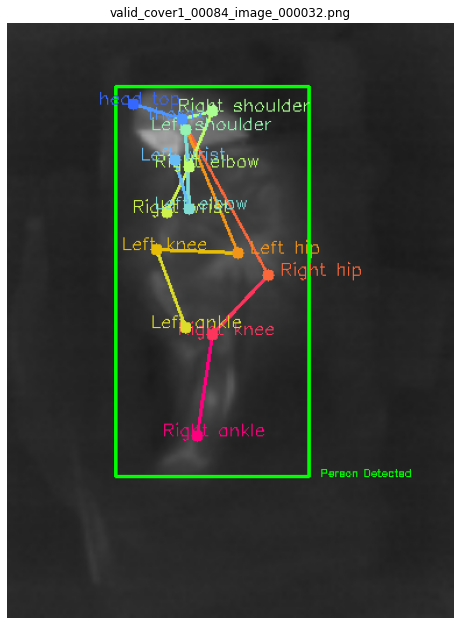

In [26]:
idx=200
filename = IMAGES[idx]['file_name']
path = '{}/{}'.format(val_dir, filename)
img = load_image(path)
# img = image
x, y, w, h = ANNOTATIONS[idx]['bbox']
kps = np.array(ANNOTATIONS[idx]['keypoints']).reshape(14, 3)[...,:2]
img = cv2.rectangle(img.astype(float),(x,y),(x+w,y+h),(0,255,0),2)
img = cv2.putText(img,'Person Detected',(x+w+10,y+h),0,0.3,(0,255,0))
img = draw_kp(img, kps, KPLINES, line_th=2, circle_th=5, fontScale=0.5, text_th =1, text=True)
plt.figure(figsize=(8,12))
plt.imshow(img.astype(np.uint8))
plt.axis('OFF')
plt.title(filename);

# 5. Installation

In [27]:
%cd {MODEL_DIR}
!mkdir -p {MODEL_DIR}/vipcup2021/evopose2d
!unzip -q {MODEL_DIR}/evopose2d.zip -d {MODEL_DIR}/vipcup2021/evopose2d
%cd {MODEL_DIR}/vipcup2021/evopose2d
!pip install -r requirements.txt

/content
/content/vipcup2021/evopose2d
     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 462 kB 75.3 MB/s 
     |████████████████████████████████| 2.9 MB 58.3 MB/s 
     |████████████████████████████████| 3.8 MB 68.7 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow

# 6. TFRecord Dataset

## Write `tfrec` Data

In [28]:
!python3 write_tfrecords.py --coco {DATA_DIR}/coco2017 --write {DATA_DIR}/tfrecord --shard-size 100 --splits train val

2021-08-08 21:33:58.103196: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
writing /content/vipcup2021-dataset/tfrecord/train/00000.tfrecord:   0% 0/36 [00:00<?, ?it/s]2021-08-08 21:34:00.215447: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-08 21:34:00.220738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-08 21:34:00.275303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-08 21:34:00.275890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
co

In [ ]:
# %cd {DATA_DIR}

# 7. EvoPose2D Config
Change following parameters accordingly
* **TFRECORDS** : path of tfrecords, `tfrec_path`
* **TRAIN_SAMPLES** : Number of train images, 
    * **only-train** : `1350`
    *  **pseudo-train** : `3600`
* **CKPT_PATH** : COCO pretrained model, `evopose2d_L.h5`
* **BATCH_SIZE** : Set batch_size according to the machine. Recommended `train` : **4** & `val` : **8**
* **EPOCHS** : `50`

In [31]:
%%writefile {MODEL_DIR}/vipcup2021/evopose2d/configs/evopose2d_L.yaml

MODEL:
    TYPE: 'evopose'
    GENOTYPE: [
        [ 3, 1, 2, 1 ],
        [ 3, 3, 3, 2 ],
        [ 5, 2, 5, 2 ],
        [ 3, 4, 10, 2 ],
        [ 5, 2, 14, 1 ],
        [ 5, 4, 16, 1 ],
        [ 3, 2, 10, 1 ]
  ]
    LOAD_WEIGHTS: false # imagenet weights
    WIDTH_COEFFICIENT: 1.
    DEPTH_COEFFICIENT: 1.
    DEPTH_DIVISOR: 8
    ACTIVATION: 'swish'
    HEAD_BLOCKS: 3
    HEAD_KERNEL: 3
    HEAD_CHANNELS: 128
    HEAD_ACTIVATION: 'swish'
    FINAL_KERNEL: 1
    CKPT_PATH: 'models/coco_ckpt/evopose2d_L.h5' # coco weights

TRAIN:
    BATCH_SIZE: 4
    EPOCHS: 100
    BASE_LR: 0.00010 # 1.
    SCALE_LR: True
    WARMUP_EPOCHS: 5 # 2.
    WARMUP_FACTOR: 0.02 # 3.
    LR_SCHEDULE: 'warmup_cosine_decay' #'warmup_piecewise' # 4.
    DECAY_FACTOR: 0.1 # 4.
    DECAY_EPOCHS: [5, 50] # 5.
    SEED: 0 # 6.
    SAVE_META: true

VAL:
    BATCH_SIZE: 8
    DROP_REMAINDER: false
    DET: false
    SCORE_THRESH: 0.2

DATASET:
    INPUT_SHAPE:  [512, 384, 3]
    ORIGINAL_SHAPE: [160, 120, 3]
    NORM: True
    MEANS: [0.485, 0.456, 0.406]
    STDS: [0.229, 0.224, 0.225]
    FLIP_PROB: 0.50
    HALF_BODY_PROB: 0.0
    HALF_BODY_MIN_KP: 8
    SCALE_FACTOR: 0.3
    ROT_PROB: 0.6
    ROT_FACTOR: 40
    COLOR_AUG: True
    SAT: [0.7, 1.3]
    CONT: [0.8, 1.2]
    BRI: 0.1
    HUE: 0.01
    TFRECORDS: '/content/vipcup2021-dataset/tfrecord' # please copy the `tfrec_path` from Diretories cell
    ANNOT: ''
    TRAIN_SAMPLES: 360 # 3600 for pseudo-training 1530 for normal-training
    VAL_SAMPLES: 45
    CACHE: true
    BFLOAT16: false

Overwriting /content/vipcup2021/evopose2d/configs/evopose2d_L.yaml


# 8. Training

In [32]:
!python3 train.py -c evopose2d_L.yaml

Running on single GPU  /device:GPU:0
Number of accelerators:  1
==================== Training ====================
Loading ckpt from models/coco_ckpt/evopose2d_L.h5
Training evopose2d_L (14.71M / 17.68G) on GPU/CPU for 100 epochs

Epoch :   0% 0/100 [00:00<?, ?it/s]
Epoch :   1% 1/100 [02:37<4:20:13, 157.71s/it]Traceback (most recent call last):
  File "train.py", line 243, in <module>
    model, meta_data = train(strategy, cfg)
  File "train.py", line 145, in train
    train_step(train_iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 2943, in __call__
    filtered_flat_args, captured_inputs=graph_function.

## Best CKPT

In [33]:
ls {MODEL_DIR}/vipcup2021/evopose2d/models

coco_ckpt/  evopose2d_L_best_ckpt.h5  evopose2d_L_meta.pkl  vip_ckpt/


## Copy Best Weight to `DATA_DIR`

In [34]:
shutil.copy('models/evopose2d_L_best_ckpt.h5', f'{MODEL_DIR}/best.h5')

'/content/best.h5'

# 9. Check Prediction
Check only few `test` images for sanity check

In [35]:
TEST_DIR  = '/content/vipcup2021-dataset/test1'

In [36]:
!mkdir - p predictions

In [37]:
!python3 detect.py -c evopose2d_L.yaml -d {TEST_DIR} -s predictions --max-det 50 --ckpt {MODEL_DIR}/best.h5

2021-08-08 21:40:14.928600: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

Loading Model:
2021-08-08 21:40:17.142867: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-08 21:40:17.147474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-08 21:40:17.184073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-08 21:40:17.184645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-08 21:40:17.184690: I tensorflow/stream_executor/platform/d

## Visualization

In [38]:
from glob import glob
paths = glob(f'predictions/*png')
len(paths)

43

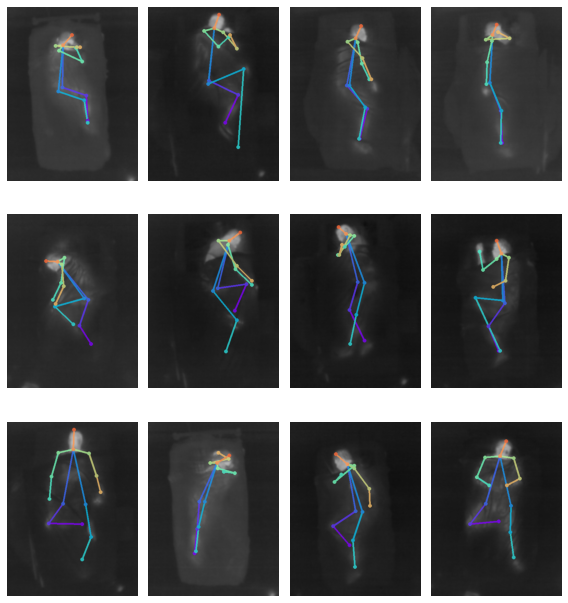

In [39]:
import matplotlib.pyplot as plt
row=3; col=4
plt.figure(figsize=(2*col,3*row))
for idx in range(row*col):
    plt.subplot(row, col, idx+1)
    plt.imshow(plt.imread(paths[idx]))
    plt.axis('OFF')
plt.tight_layout()
plt.show()

# 10. Submission

In [41]:
SUB_NAME  = 'proletarian-512-01' # Submission name don't use whitespace
TEST_DIR  = '/content/vipcup2021-dataset/test1'
CKPT_PATH = f'{MODEL_DIR}/best.h5' # best weight path
TTAS      = 10 # number of test-time-augmentation

In [43]:
!mkdir -p submission

In [44]:
!python3 submit.py -c evopose2d_L.yaml -d {TEST_DIR} --json-dir submission --zip-path submission/proletarians_{SUB_NAME}.zip --ckpt {CKPT_PATH} --ttas {TTAS}

2021-08-08 21:42:32.778865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

Loading Model:
2021-08-08 21:42:34.962347: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-08 21:42:34.963350: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-08 21:42:34.994626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-08 21:42:34.995220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-08 21:42:34.995276: I tensorflow/stream_executor/platform/d

## Submission Files

In [45]:
ls {MODEL_DIR}/vipcup2021/evopose2d/submission

info.json  preds_all.json  preds.json  proletarians_proletarian-512-01.zip


## Remove Files
* Removing `info.json` from `/submission` to avoid confusion with `/pseudo`

In [46]:
!rm -r submission/info.json

# 11. Pseudo Label

In [47]:
new_pseudo_df  = df[(df.label!='uncover') & (df.split=='train')]
del new_pseudo_df['kps']

## Prepare Images for Pseudo-Labeling

In [48]:
!mkdir -p {DATA_DIR}/tmp/images
for idx in tqdm(range(new_pseudo_df.shape[0])):
    row = new_pseudo_df.iloc[idx]
    shutil.copy(row.image_path, f'{DATA_DIR}/tmp/images/{row.filename}')

In [49]:
assert len(glob(f'{DATA_DIR}/tmp/images/*'))==2250 # check if all cover1 & cover2 images have been found

## Create Pseudo Labels

In [50]:
!mkdir -p pseudo

In [51]:
!python3 submit.py -c evopose2d_L.yaml -d {DATA_DIR}/tmp/images --json-dir pseudo --zip-path pseudo/pseudo_labels.zip --ckpt {CKPT_PATH} --ttas {TTAS}

2021-08-08 21:44:11.459849: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

Loading Model:
2021-08-08 21:44:13.793677: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-08 21:44:13.794754: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-08 21:44:13.828134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-08 21:44:13.828715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-08 21:44:13.828762: I tensorflow/stream_executor/platform/d

## Pseudo Files

In [53]:
ls {MODEL_DIR}/vipcup2021/evopose2d/pseudo

info.json  preds_all.json  preds.json  pseudo_labels.zip


## Pseudo Label Usage
* Use `vipcup2021/evopose2d/pseudo` as `PSEUDO_DIR` for **Pseudo-Training**
* Use `{DATA_DIR}/pseudo.csv` for Pseudo Training of **TransPose** & **MMPose** models.

# 12. Remove Directories
* After the training is complete, use `/pseudo` directory of **Pseudo-Training** and `/submission` for submission.
* Remove rest of the directories. 
* For **Pseudo-Training** create the **COCO-Format** & `tfrec` dataset. Do **Pseudo-Training** for `10` times.

In [54]:
!rm -r {DATA_DIR}/tmp/images
!rm -r {DATA_DIR}/coco2017
!rm -r {DATA_DIR}/tfrecord
# !rm -r {DATA_DIR}/vipcup2021